In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_recall_curve, classification_report, confusion_matrix, average_precision_score, roc_curve, auc, multilabel_confusion_matrix
from pylab import bone, pcolor, colorbar, plot, show, title

In [2]:
def print_input_files():
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
def dump_text_file(fname):
    with open(fname, 'r') as f:
        print(f.read())
def dump_csv_file(fname, count=5):
    df = pd.read_csv(fname)
    if count < 0:
        count = df.shape[0]
    return df.head(count)
ds_nbaiot = '/kaggle/input/nbaiot-dataset'
dn_nbaiot = ['Danmini_Doorbell', 'Ecobee_Thermostat', 'Ennio_Doorbell', 'Philips_B120N10_Baby_Monitor', 'Provision_PT_737E_Security_Camera', 'Provision_PT_838_Security_Camera', 'Samsung_SNH_1011_N_Webcam', 'SimpleHome_XCS7_1002_WHT_Security_Camera', 'SimpleHome_XCS7_1003_WHT_Security_Camera']
def fname(ds, f):
    if '.csv' not in f:
        f = f'{f}.csv'
    return os.path.join(ds, f)

def fname_nbaiot(f):
    return fname(ds_nbaiot, f)

def get_nbaiot_device_files():
    nbaiot_all_files = dump_csv_file(fname_nbaiot('data_summary'), -1)
    nbaiot_all_files = nbaiot_all_files.iloc[:,0:1].values
    device_id = 1
    indices = []
    for j in range(len(nbaiot_all_files)):
        if str(device_id) not in str(nbaiot_all_files[j]):
            indices.append(j)
            device_id += 1
    nbaiot_device_files = np.split(nbaiot_all_files, indices)
    return nbaiot_device_files

def get_nbaiot_device_data(device_id, count_norm=-1, count_anom=-1):
    if device_id < 1 or device_id > 9:
        assert False, "Please provide a valid device ID 1-9, both inclusive"
    if count_anom == -1:
        count_anom = count_norm
    device_index = device_id -1
    device_files = get_nbaiot_device_files()
    device_file = device_files[device_index]
    df = pd.DataFrame()
    y = []
    for i in range(len(device_file)):
        fname = str(device_file[i][0])
        df_c = pd.read_csv(fname_nbaiot(fname))
        count = count_anom
        if 'benign' in fname:
            count = count_norm
        rows = count if count >=0 else df_c.shape[0]
        print("processing", fname, "rows =", rows)
        y_np = np.ones(rows) if 'benign' in fname else np.zeros(rows)
        y.extend(y_np.tolist())
        df = pd.concat([df.iloc[:,:].reset_index(drop=True),
                      df_c.iloc[:rows,:].reset_index(drop=True)], axis=0)
    X = df.iloc[:,:].values
    y = np.array(y)
    return (X, y)

def get_nbaiot_devices_data():
    devices_data = []
    for i in range(9):
        device_id = i + 1
        (X, y) = get_nbaiot_device_data(device_id)
        devices_data.append((X, y))
    return devices_data
#print_input_files()

In [3]:
# ********************************************************************************************************
# This is a third party implementation
# https://github.com/JustGlowing/minisom
# MiniSom by Giuseppe Vettigli is licensed under the Creative Commons Attribution 3.0 Unported License.
# To view a copy of this license, visit http://creativecommons.org/licenses/by/3.0/.
# ********************************************************************************************************

from math import sqrt

from numpy import (array, unravel_index, nditer, linalg, random, subtract,
                   power, exp, pi, zeros, arange, outer, meshgrid, dot)
from collections import defaultdict
from warnings import warn


"""
    Minimalistic implementation of the Self Organizing Maps (SOM).
"""


def fast_norm(x):
    """Returns norm-2 of a 1-D numpy array.
    * faster than linalg.norm in case of 1-D arrays (numpy 1.9.2rc1).
    """
    return sqrt(dot(x, x.T))


class MiniSom(object):
    def __init__(self, x, y, input_len, sigma=1.0, learning_rate=0.5, decay_function=None, random_seed=None):
        """
            Initializes a Self Organizing Maps.
            x,y - dimensions of the SOM
            input_len - number of the elements of the vectors in input
            sigma - spread of the neighborhood function (Gaussian), needs to be adequate to the dimensions of the map.
            (at the iteration t we have sigma(t) = sigma / (1 + t/T) where T is #num_iteration/2)
            learning_rate - initial learning rate
            (at the iteration t we have learning_rate(t) = learning_rate / (1 + t/T) where T is #num_iteration/2)
            decay_function, function that reduces learning_rate and sigma at each iteration
                            default function: lambda x,current_iteration,max_iter: x/(1+current_iteration/max_iter)
            random_seed, random seed to use.
        """
        if sigma >= x/2.0 or sigma >= y/2.0:
            warn('Warning: sigma is too high for the dimension of the map.')
        if random_seed:
            self.random_generator = random.RandomState(random_seed)
        else:
            self.random_generator = random.RandomState(random_seed)
        if decay_function:
            self._decay_function = decay_function
        else:
            self._decay_function = lambda x, t, max_iter: x/(1+t/max_iter)
        self.learning_rate = learning_rate
        self.sigma = sigma
        self.weights = self.random_generator.rand(x,y,input_len)*2-1 # random initialization
        for i in range(x):
            for j in range(y):
                self.weights[i,j] = self.weights[i,j] / fast_norm(self.weights[i,j]) # normalization
        self.activation_map = zeros((x,y))
        self.neigx = arange(x)
        self.neigy = arange(y) # used to evaluate the neighborhood function
        self.neighborhood = self.gaussian

    def _activate(self, x):
        """ Updates matrix activation_map, in this matrix the element i,j is the response of the neuron i,j to x """
        s = subtract(x, self.weights) # x - w
        it = nditer(self.activation_map, flags=['multi_index'])
        while not it.finished:
            self.activation_map[it.multi_index] = fast_norm(s[it.multi_index])  # || x - w ||
            it.iternext()

    def activate(self, x):
        """ Returns the activation map to x """
        self._activate(x)
        return self.activation_map

    def gaussian(self, c, sigma):
        """ Returns a Gaussian centered in c """
        d = 2*pi*sigma*sigma
        ax = exp(-power(self.neigx-c[0], 2)/d)
        ay = exp(-power(self.neigy-c[1], 2)/d)
        return outer(ax, ay)  # the external product gives a matrix

    def diff_gaussian(self, c, sigma):
        """ Mexican hat centered in c (unused) """
        xx, yy = meshgrid(self.neigx, self.neigy)
        p = power(xx-c[0], 2) + power(yy-c[1], 2)
        d = 2*pi*sigma*sigma
        return exp(-p/d)*(1-2/d*p)

    def winner(self, x):
        """ Computes the coordinates of the winning neuron for the sample x """
        self._activate(x)
        return unravel_index(self.activation_map.argmin(), self.activation_map.shape)

    def update(self, x, win, t):
        """
            Updates the weights of the neurons.
            x - current pattern to learn
            win - position of the winning neuron for x (array or tuple).
            t - iteration index
        """
        eta = self._decay_function(self.learning_rate, t, self.T)
        sig = self._decay_function(self.sigma, t, self.T) # sigma and learning rate decrease with the same rule
        g = self.neighborhood(win, sig)*eta # improves the performances
        it = nditer(g, flags=['multi_index'])
        while not it.finished:
            # eta * neighborhood_function * (x-w)
            self.weights[it.multi_index] += g[it.multi_index]*(x-self.weights[it.multi_index])
            # normalization
            self.weights[it.multi_index] = self.weights[it.multi_index] / fast_norm(self.weights[it.multi_index])
            it.iternext()

    def quantization(self, data):
        """ Assigns a code book (weights vector of the winning neuron) to each sample in data. """
        q = zeros(data.shape)
        for i, x in enumerate(data):
            q[i] = self.weights[self.winner(x)]
        return q

    def random_weights_init(self, data):
        """ Initializes the weights of the SOM picking random samples from data """
        it = nditer(self.activation_map, flags=['multi_index'])
        while not it.finished:
            self.weights[it.multi_index] = data[self.random_generator.randint(len(data))]
            self.weights[it.multi_index] = self.weights[it.multi_index]/fast_norm(self.weights[it.multi_index])
            it.iternext()

    def train_random(self, data, num_iteration):
        """ Trains the SOM picking samples at random from data """
        self._init_T(num_iteration)
        for iteration in range(num_iteration):
            rand_i = self.random_generator.randint(len(data)) # pick a random sample
            self.update(data[rand_i], self.winner(data[rand_i]), iteration)

    def train_batch(self, data, num_iteration):
        """ Trains using all the vectors in data sequentially """
        self._init_T(len(data)*num_iteration)
        iteration = 0
        while iteration < num_iteration:
            idx = iteration % (len(data)-1)
            self.update(data[idx], self.winner(data[idx]), iteration)
            iteration += 1

    def _init_T(self, num_iteration):
        """ Initializes the parameter T needed to adjust the learning rate """
        self.T = num_iteration/2  # keeps the learning rate nearly constant for the last half of the iterations

    def distance_map(self):
        """ Returns the distance map of the weights.
            Each cell is the normalised sum of the distances between a neuron and its neighbours.
        """
        um = zeros((self.weights.shape[0], self.weights.shape[1]))
        it = nditer(um, flags=['multi_index'])
        while not it.finished:
            for ii in range(it.multi_index[0]-1, it.multi_index[0]+2):
                for jj in range(it.multi_index[1]-1, it.multi_index[1]+2):
                    if ii >= 0 and ii < self.weights.shape[0] and jj >= 0 and jj < self.weights.shape[1]:
                        um[it.multi_index] += fast_norm(self.weights[ii, jj, :]-self.weights[it.multi_index])
            it.iternext()
        um = um/um.max()
        return um

    def activation_response(self, data):
        """
            Returns a matrix where the element i,j is the number of times
            that the neuron i,j have been winner.
        """
        a = zeros((self.weights.shape[0], self.weights.shape[1]))
        for x in data:
            a[self.winner(x)] += 1
        return a

    def quantization_error(self, data):
        """
            Returns the quantization error computed as the average distance between
            each input sample and its best matching unit.
        """
        error = 0
        for x in data:
            error += fast_norm(x-self.weights[self.winner(x)])
        return error/len(data)

    def win_map(self, data):
        """
            Returns a dictionary wm where wm[(i,j)] is a list with all the patterns
            that have been mapped in the position i,j.
        """
        winmap = defaultdict(list)
        for x in data:
            winmap[self.winner(x)].append(x)
        return winmap

### unit tests
from numpy.testing import assert_almost_equal, assert_array_almost_equal, assert_array_equal


class TestMinisom:
    def setup_method(self, method):
        self.som = MiniSom(5, 5, 1)
        for i in range(5):
            for j in range(5):
                assert_almost_equal(1.0, linalg.norm(self.som.weights[i,j]))  # checking weights normalization
        self.som.weights = zeros((5, 5))  # fake weights
        self.som.weights[2, 3] = 5.0
        self.som.weights[1, 1] = 2.0

    def test_decay_function(self):
        assert self.som._decay_function(1., 2., 3.) == 1./(1.+2./3.)

    def test_fast_norm(self):
        assert fast_norm(array([1, 3])) == sqrt(1+9)

    def test_gaussian(self):
        bell = self.som.gaussian((2, 2), 1)
        assert bell.max() == 1.0
        assert bell.argmax() == 12  # unravel(12) = (2,2)

    def test_win_map(self):
        winners = self.som.win_map([5.0, 2.0])
        assert winners[(2, 3)][0] == 5.0
        assert winners[(1, 1)][0] == 2.0

    def test_activation_reponse(self):
        response = self.som.activation_response([5.0, 2.0])
        assert response[2, 3] == 1
        assert response[1, 1] == 1

    def test_activate(self):
        assert self.som.activate(5.0).argmin() == 13.0  # unravel(13) = (2,3)

    def test_quantization_error(self):
        self.som.quantization_error([5, 2]) == 0.0
        self.som.quantization_error([4, 1]) == 0.5

    def test_quantization(self):
        q = self.som.quantization(array([4, 2]))
        assert q[0] == 5.0
        assert q[1] == 2.0

    def test_random_seed(self):
        som1 = MiniSom(5, 5, 2, sigma=1.0, learning_rate=0.5, random_seed=1)
        som2 = MiniSom(5, 5, 2, sigma=1.0, learning_rate=0.5, random_seed=1)
        assert_array_almost_equal(som1.weights, som2.weights)  # same initialization
        data = random.rand(100,2)
        som1 = MiniSom(5, 5, 2, sigma=1.0, learning_rate=0.5, random_seed=1)
        som1.train_random(data,10)
        som2 = MiniSom(5, 5, 2, sigma=1.0, learning_rate=0.5, random_seed=1)
        som2.train_random(data,10)
        assert_array_almost_equal(som1.weights,som2.weights)  # same state after training

    def test_train_batch(self):
        som = MiniSom(5, 5, 2, sigma=1.0, learning_rate=0.5, random_seed=1)
        data = array([[4, 2], [3, 1]])
        q1 = som.quantization_error(data)
        som.train_batch(data, 10)
        assert q1 > som.quantization_error(data)

    def test_train_random(self):
        som = MiniSom(5, 5, 2, sigma=1.0, learning_rate=0.5, random_seed=1)
        data = array([[4, 2], [3, 1]])
        q1 = som.quantization_error(data)
        som.train_random(data, 10)
        assert q1 > som.quantization_error(data)

    def test_random_weights_init(self):
        som = MiniSom(2, 2, 2, random_seed=1)
        som.random_weights_init(array([[1.0, .0]]))
        for w in som.weights:
            assert_array_equal(w[0], array([1.0, .0]))

In [4]:
class Som:
    def __init__(self, x=20, y=None):
        '''
            parameter: x, y, size of the grid,
                     default: 20x20, if y is not supplied, y is the same as x
        '''
        self.som = None
        self.map_x = x
        if not y:
            self.map_y = x # square grid
        else:
            self.map_y = y

    def fit(self, X):
        '''
            Fit SOM to the input data.
            Parameters: X = a numpy array and it should contain
                            all columns as features and any manually
                            labeled columns should be removed before
                            calling this function.
        '''
        nb_features = X.shape[1] # number of features
        som = MiniSom(x = self.map_x, y = self.map_y, input_len = nb_features, sigma = 1.0, learning_rate = 0.5)
        som.random_weights_init(X)
        som.train_random(data = X, num_iteration = 2000)
        dm = som.distance_map()
        mid = []
        for x in X:
            w = som.winner(x)
            (x,y) = w
            mid.append(dm[x][y])

        self.dm = dm
        self.som = som
        self.grid = (self.map_x, self.map_y)
        self.mid = mid

    def predict(self, threshold = 0.02, anomaly_label=0):
        '''Predict data as normal or anomalous based upon mean inter-neuron distance.
             Need to call fit() before calling this.
             Parameters: threshold = the threshold (default = 0.02) that is used to
                                     determine if normal = 1 (when mid <= threshold),
                                     or anomalous = 0 otherwise.
                         anomaly_label = the value to label anomalies, default = 0'''
        if self.som is None:
            raise Exception('Call fit() before calling this')

        y_pred = []
        for m in self.mid:
            normal = (1 if m <= threshold else anomaly_label)
            y_pred.append(normal)
        return y_pred

    def plot_marker(self, xy, m, c):
        plot(xy[0] + 0.5,
             xy[1] + 0.5,
             m,
             markeredgecolor = c,
             markerfacecolor = 'None',
             markersize = 10,
             markeredgewidth = 2)

    def plot_distance_map_labels(self, t, X, Y):
        '''Plots distance map with labels. Need to call fit() before calling this.
             Parameters: X = input features
                         Y = labels, 1 = normal, 0 = anomalous.'''
        if self.som is None:
            raise Exception('Call fit() before calling this')

        red_set = set() # normal instances
        green_set = set() # anomalous instances
        for i, x in enumerate(X):
            w = self.som.winner(x)
            if int(Y[i]) == 0:
                red_set.add(w)
            else:
                green_set.add(w)
        bone()
        pcolor(self.dm.T)
        colorbar()
        (map_x, map_y) = self.grid
        for x in range(map_x):
            for y in range(map_y):
                xy = (x,y)
                if (xy in red_set) and (xy in green_set):
                    self.plot_marker(xy, 'h', 'y')
                elif xy in red_set:
                    self.plot_marker(xy, 'o', 'r')
                elif xy in green_set:
                    self.plot_marker(xy, 's', 'g')
                else:
                    pass #plot_marker(xy, 'v', 'b')
        title(t)
        show()

In [5]:
# Imports
import os
import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.python.client import device_lib
import seaborn as sns
import matplotlib
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data

from keras.layers import Input, Dense
from keras import regularizers, Model
from keras.models import Sequential

from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_recall_curve, classification_report, confusion_matrix, average_precision_score, roc_curve, auc
from sklearn.datasets import make_blobs

from imageio import imwrite
#from scipy.misc import imsave

%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from PIL import Image, ImageChops

Using TensorFlow backend.


In [6]:
# Test MiniSom
'''
outliers_percentage = 0.35
inliers = 300
outliers = int(inliers * outliers_percentage)
data = make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[.3, .3],
                  n_samples=inliers, random_state=0)[0]
data = scale(data)
data = np.concatenate([data, 
                       (np.random.rand(outliers, 2)-.5)*4.])
som = MiniSom(2, 1, data.shape[1], sigma=1, learning_rate=0.5, random_seed=10)
som.train_batch(data, 100)  # random training

quantization_errors = np.linalg.norm(som.quantization(data) - data, axis=1)
error_treshold = np.percentile(quantization_errors, 
                               100*(1-outliers_percentage)+5)
is_outlier = quantization_errors > error_treshold

plt.figure(figsize=(8, 8))
plt.scatter(data[~is_outlier, 0], data[~is_outlier, 1],
            label='inlier')
plt.scatter(data[is_outlier, 0], data[is_outlier, 1],
            label='outlier')
plt.legend()
#plt.savefig('resulting_images/som_outliers_detection.png')
plt.show()
'''

"\noutliers_percentage = 0.35\ninliers = 300\noutliers = int(inliers * outliers_percentage)\ndata = make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[.3, .3],\n                  n_samples=inliers, random_state=0)[0]\ndata = scale(data)\ndata = np.concatenate([data, \n                       (np.random.rand(outliers, 2)-.5)*4.])\nsom = MiniSom(2, 1, data.shape[1], sigma=1, learning_rate=0.5, random_seed=10)\nsom.train_batch(data, 100)  # random training\n\nquantization_errors = np.linalg.norm(som.quantization(data) - data, axis=1)\nerror_treshold = np.percentile(quantization_errors, \n                               100*(1-outliers_percentage)+5)\nis_outlier = quantization_errors > error_treshold\n\nplt.figure(figsize=(8, 8))\nplt.scatter(data[~is_outlier, 0], data[~is_outlier, 1],\n            label='inlier')\nplt.scatter(data[is_outlier, 0], data[is_outlier, 1],\n            label='outlier')\nplt.legend()\n#plt.savefig('resulting_images/som_outliers_detection.png')\nplt.show()\n"

processing 1.benign.csv rows = 49548
processing 1.gafgyt.combo.csv rows = 59718
processing 1.gafgyt.junk.csv rows = 29068
processing 1.gafgyt.scan.csv rows = 29849
processing 1.gafgyt.tcp.csv rows = 92141
processing 1.gafgyt.udp.csv rows = 105874
processing 1.mirai.ack.csv rows = 102195
processing 1.mirai.scan.csv rows = 107685
processing 1.mirai.syn.csv rows = 122573
processing 1.mirai.udp.csv rows = 237665
processing 1.mirai.udpplain.csv rows = 81982
X.shape (1018298, 115) y.shape (1018298,)


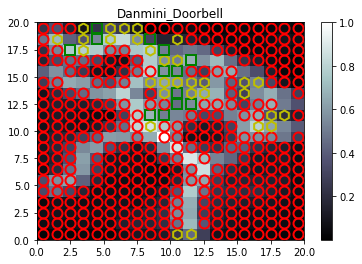

Danmini_Doorbell
threshold,acc,tn,fp,fn,tp
0.00,0.95,968750,0,49548,0
0.01,0.76,770817,197933,49548,0
0.02,0.76,769024,199726,49548,0
0.03,0.74,755459,213291,49548,0
0.04,0.70,717167,251583,49548,0
0.05,0.68,690773,277977,49548,0
0.06,0.66,669949,298801,49548,0
0.07,0.61,618117,350633,49548,0
0.08,0.54,550502,418248,49417,131
0.09,0.48,493097,475653,49417,131
0.10,0.45,457058,511692,49417,131
0.11,0.41,415045,553705,49417,131
0.12,0.39,393468,575282,49411,137
0.13,0.35,356722,612028,49411,137
0.14,0.33,338452,630298,49411,137
0.15,0.30,309049,659701,49411,137
0.16,0.29,290960,677790,49411,137
0.17,0.27,275548,693202,49411,137
0.18,0.25,254117,714633,49410,138
0.19,0.23,237043,731707,49410,138
0.20,0.22,227254,741496,49410,138
0.21,0.22,223702,745048,49405,143
0.22,0.21,213573,755177,49405,143
0.23,0.19,195781,772969,49404,144
0.24,0.18,183085,785665,49403,145
0.25,0.18,179762,788988,49403,145
0.26,0.17,178055,790695,49403,145
0.27,0.17,177203,791547,49343,205
0.28,0.16,166640,802110,49

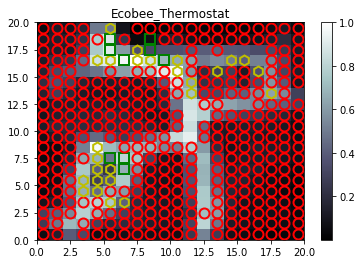

Ecobee_Thermostat
threshold,acc,tn,fp,fn,tp
0.00,0.98,822763,0,13113,0
0.01,0.75,623154,199609,13113,0
0.02,0.75,623154,199609,13113,0
0.03,0.74,621418,201345,13113,0
0.04,0.72,603113,219650,13113,0
0.05,0.70,583495,239268,13113,0
0.06,0.68,568423,254340,13113,0
0.07,0.65,545715,277048,13108,5
0.08,0.63,523808,298955,13108,5
0.09,0.59,489521,333242,13108,5
0.10,0.55,457418,365345,13108,5
0.11,0.52,438143,384620,13108,5
0.12,0.48,404672,418091,13108,5
0.13,0.43,360833,461930,13108,5
0.14,0.37,311494,511269,13108,5
0.15,0.32,270144,552619,13108,5
0.16,0.30,248035,574728,13108,5
0.17,0.26,219634,603129,13108,5
0.18,0.26,218497,604266,13108,5
0.19,0.24,196510,626253,13108,5
0.20,0.22,182518,640245,13108,5
0.21,0.21,175665,647098,13108,5
0.22,0.20,169644,653119,13108,5
0.23,0.20,163793,658970,13108,5
0.24,0.20,163732,659031,13108,5
0.25,0.19,159728,663035,12355,758
0.26,0.19,156262,666501,12355,758
0.27,0.19,155216,667547,12355,758
0.28,0.18,145938,676825,12354,759
0.29,0.17,140468,682295,1

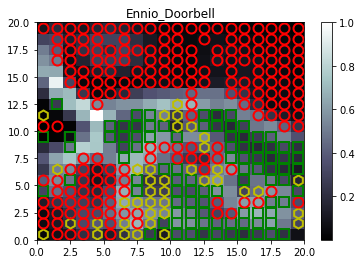

Ennio_Doorbell
threshold,acc,tn,fp,fn,tp
0.00,0.89,316400,0,39100,0
0.01,0.31,110274,206126,39098,2
0.02,0.31,110274,206126,39098,2
0.03,0.28,100781,215619,39098,2
0.04,0.24,84759,231641,39080,20
0.05,0.22,77963,238437,39080,20
0.06,0.19,65944,250456,39080,20
0.07,0.17,60144,256256,39079,21
0.08,0.15,54809,261591,39079,21
0.09,0.14,50541,265859,39079,21
0.10,0.13,47953,268447,39079,21
0.11,0.13,45153,271247,39079,21
0.12,0.13,41714,274686,35976,3124
0.13,0.11,37102,279298,35976,3124
0.14,0.11,36506,279894,35976,3124
0.15,0.11,35938,280462,35911,3189
0.16,0.11,35938,280462,35911,3189
0.17,0.11,35736,280664,34687,4413
0.18,0.11,35520,280880,33863,5237
0.19,0.12,33959,282441,32069,7031
0.20,0.11,33337,283063,31602,7498
0.21,0.11,32672,283728,31323,7777
0.22,0.11,30611,285789,30939,8161
0.23,0.12,29327,287073,25585,13515
0.24,0.11,25367,291033,24555,14545
0.25,0.11,23907,292493,24360,14740
0.26,0.11,23907,292493,22607,16493
0.27,0.13,23253,293147,16326,22774
0.28,0.13,22731,293669,16034,23

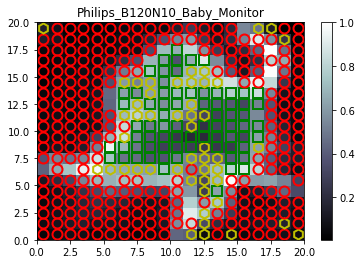

Philips_B120N10_Baby_Monitor
threshold,acc,tn,fp,fn,tp
0.00,0.84,923437,0,175240,0
0.01,0.84,923423,14,175240,0
0.02,0.84,922246,1191,175240,0
0.03,0.83,906738,16699,175240,0
0.04,0.82,898517,24920,175240,0
0.05,0.77,843781,79656,175240,0
0.06,0.71,784102,139335,175228,12
0.07,0.64,704249,219188,175115,125
0.08,0.59,651185,272252,175115,125
0.09,0.57,624784,298653,175115,125
0.10,0.53,578062,345375,175115,125
0.11,0.50,550520,372917,175115,125
0.12,0.46,502393,421044,175115,125
0.13,0.45,492552,430885,175115,125
0.14,0.26,285729,637708,175110,130
0.15,0.24,258481,664956,175110,130
0.16,0.23,247161,676276,174983,257
0.17,0.21,235391,688046,174983,257
0.18,0.21,234765,688672,174983,257
0.19,0.20,218079,705358,170920,4320
0.20,0.21,216046,707391,161165,14075
0.21,0.20,205868,717569,161165,14075
0.22,0.19,198404,725033,161165,14075
0.23,0.19,193873,729564,161165,14075
0.24,0.18,180889,742548,157716,17524
0.25,0.18,176539,746898,157716,17524
0.26,0.20,176519,746918,137025,38215
0.27,0.19,16

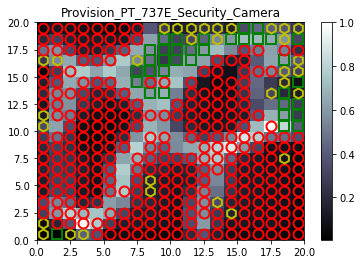

Provision_PT_737E_Security_Camera
threshold,acc,tn,fp,fn,tp
0.00,0.92,766106,0,62154,0
0.01,0.92,766105,1,62149,5
0.02,0.92,764729,1377,62149,5
0.03,0.92,764729,1377,62149,5
0.04,0.92,761060,5046,62149,5
0.05,0.91,751435,14671,62149,5
0.06,0.62,516874,249232,62089,65
0.07,0.60,496448,269658,62089,65
0.08,0.56,464521,301585,62089,65
0.09,0.54,441530,324576,59415,2739
0.10,0.50,415340,350766,59411,2743
0.11,0.47,385854,380252,59411,2743
0.12,0.43,356964,409142,59411,2743
0.13,0.41,338673,427433,59411,2743
0.14,0.39,308082,458024,50610,11544
0.15,0.36,290722,475384,50610,11544
0.16,0.34,268684,497422,48545,13609
0.17,0.31,244386,521720,48544,13610
0.18,0.30,232305,533801,48542,13612
0.19,0.31,231486,534620,40113,22041
0.20,0.29,218329,547777,37210,24944
0.21,0.28,210027,556079,37210,24944
0.22,0.28,203534,562572,37042,25112
0.23,0.28,203532,562574,36856,25298
0.24,0.27,194830,571276,36856,25298
0.25,0.26,191094,575012,36856,25298
0.26,0.24,176954,589152,36234,25920
0.27,0.24,170593,595513

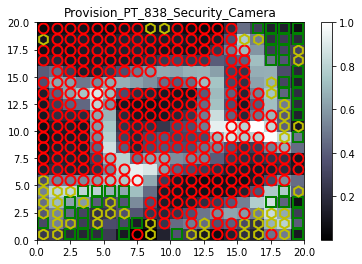

Provision_PT_838_Security_Camera
threshold,acc,tn,fp,fn,tp
0.00,0.88,738377,0,98514,0
0.01,0.65,544471,193906,98465,49
0.02,0.65,544471,193906,98465,49
0.03,0.65,544471,193906,98465,49
0.04,0.65,544471,193906,98465,49
0.05,0.65,540756,197621,98465,49
0.06,0.64,534866,203511,98465,49
0.07,0.63,523075,215302,97704,810
0.08,0.62,514835,223542,97518,996
0.09,0.58,482987,255390,97516,998
0.10,0.55,458003,280374,97504,1010
0.11,0.50,413668,324709,97493,1021
0.12,0.46,387738,350639,97456,1058
0.13,0.44,363427,374950,97456,1058
0.14,0.39,327862,410515,97450,1064
0.15,0.38,307448,430929,90836,7678
0.16,0.35,286596,451781,90824,7690
0.17,0.34,276037,462340,90824,7690
0.18,0.33,264198,474179,89222,9292
0.19,0.32,254997,483380,88708,9806
0.20,0.31,245672,492705,83269,15245
0.21,0.30,233380,504997,80565,17949
0.22,0.29,222394,515983,80333,18181
0.23,0.29,219881,518496,73567,24947
0.24,0.28,210802,527575,73513,25001
0.25,0.28,197905,540472,60176,38338
0.26,0.27,183140,555237,56630,41884
0.27,0.27,18

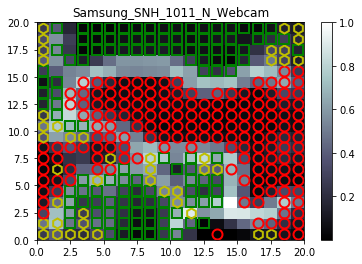

Samsung_SNH_1011_N_Webcam
threshold,acc,tn,fp,fn,tp
0.00,0.86,323072,0,52150,0
0.01,0.31,114879,208193,52150,0
0.02,0.31,114879,208193,51865,285
0.03,0.31,114160,208912,51050,1100
0.04,0.29,103764,219308,45259,6891
0.05,0.27,89524,233548,39681,12469
0.06,0.26,82165,240907,37185,14965
0.07,0.22,66827,256245,35562,16588
0.08,0.21,59245,263827,32629,19521
0.09,0.20,56008,267064,32552,19598
0.10,0.20,52780,270292,31282,20868
0.11,0.19,50056,273016,30667,21483
0.12,0.18,44671,278401,28888,23262
0.13,0.18,42787,280285,28334,23816
0.14,0.17,41274,281798,28276,23874
0.15,0.17,38979,284093,27547,24603
0.16,0.17,37628,285444,27539,24611
0.17,0.17,37628,285444,26956,25194
0.18,0.17,37628,285444,26936,25214
0.19,0.16,36501,286571,26915,25235
0.20,0.16,36062,287010,26703,25447
0.21,0.16,33660,289412,25464,26686
0.22,0.17,32007,291065,21044,31106
0.23,0.17,30191,292881,19928,32222
0.24,0.17,30191,292881,19928,32222
0.25,0.17,27959,295113,17192,34958
0.26,0.17,27716,295356,15398,36752
0.27,0.16,24288

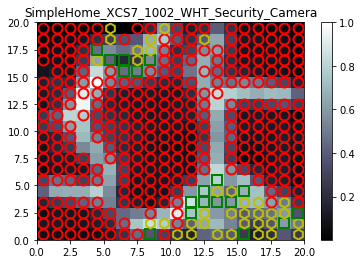

SimpleHome_XCS7_1002_WHT_Security_Camera
threshold,acc,tn,fp,fn,tp
0.00,0.95,816471,0,46585,0
0.01,0.72,624133,192338,46585,0
0.02,0.72,622457,194014,46580,5
0.03,0.71,617000,199471,46580,5
0.04,0.71,612306,204165,46580,5
0.05,0.69,598957,217514,46580,5
0.06,0.67,578526,237945,46580,5
0.07,0.66,570663,245808,46580,5
0.08,0.64,553645,262826,46580,5
0.09,0.60,521473,294998,46580,5
0.10,0.56,482969,333502,46580,5
0.11,0.51,435927,380544,46580,5
0.12,0.45,392133,424338,46580,5
0.13,0.42,358519,457952,46580,5
0.14,0.37,321822,494649,46580,5
0.15,0.35,300413,516058,45542,1043
0.16,0.33,285594,530877,45542,1043
0.17,0.32,274994,541477,45504,1081
0.18,0.32,258516,557955,29801,16784
0.19,0.31,249103,567368,29801,16784
0.20,0.30,241694,574777,29801,16784
0.21,0.29,237144,579327,29801,16784
0.22,0.29,229757,586714,25287,21298
0.23,0.28,221611,594860,25287,21298
0.24,0.27,211127,605344,25249,21336
0.25,0.26,198535,617936,23375,23210
0.26,0.26,195833,620638,20773,25812
0.27,0.24,181293,635178,20773

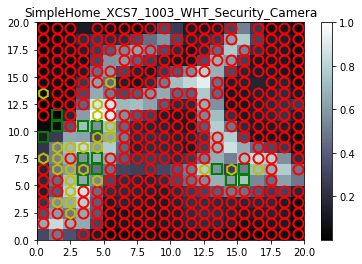

SimpleHome_XCS7_1003_WHT_Security_Camera
threshold,acc,tn,fp,fn,tp
0.00,0.98,831298,0,19528,0
0.01,0.74,630446,200852,19524,4
0.02,0.74,630423,200875,19524,4
0.03,0.74,629556,201742,19524,4
0.04,0.73,623176,208122,19524,4
0.05,0.72,616398,214900,19484,44
0.06,0.71,605298,226000,19469,59
0.07,0.68,579097,252201,19469,59
0.08,0.65,556644,274654,19469,59
0.09,0.63,531822,299476,19469,59
0.10,0.60,514190,317108,19469,59
0.11,0.56,478113,353185,19469,59
0.12,0.52,446163,385135,19469,59
0.13,0.48,409273,422025,19469,59
0.14,0.44,371565,459733,19469,59
0.15,0.41,348383,482915,19441,87
0.16,0.38,325572,505726,19441,87
0.17,0.36,304686,526612,19441,87
0.18,0.34,286358,544940,19441,87
0.19,0.31,267019,564279,19441,87
0.20,0.29,245966,585332,19441,87
0.21,0.26,223609,607689,19441,87
0.22,0.25,215352,615946,19441,87
0.23,0.23,193950,637348,19441,87
0.24,0.22,186973,644325,19441,87
0.25,0.22,184128,647170,19441,87
0.26,0.20,167014,664284,19441,87
0.27,0.19,163700,667598,19337,191
0.28,0.19,161811,6

In [7]:
for i in range(9):
    device_index = i
    device_id = i + 1
    device_name = dn_nbaiot[device_index]
    (X, y) = get_nbaiot_device_data(device_id)
    print('X.shape', X.shape, 'y.shape', y.shape)
    X_std = StandardScaler().fit_transform(X)
    som = Som()
    som.fit(X_std)
    som.plot_distance_map_labels(device_name, X_std, y)
    step = 0.01
    threshold = 0.0
    i = 1
    print(device_name)
    print("threshold,acc,tn,fp,fn,tp")
    while threshold <= 1:
        y_pred = som.predict(threshold)
        tn, fp, fn, tp = confusion_matrix(y, y_pred, labels=[0,1]).ravel()
        acc = accuracy_score(y, y_pred)
        print(f'{threshold:.2f},{acc:.2f},{tn},{fp},{fn},{tp}')
        threshold += step
        i += 1